In [1]:
import pandas as pd
import numpy as np
import os

# set working directory
os.chdir('/Users/lijiayu/Desktop/MACS_30700_Final/')

# load eurobarometer dataset
eu_data = pd.read_csv("dataset/EU/eu.csv")

# compute conditional probabilities for joint sampling
education_given_age = eu_data.groupby("age_group")["education_level"].value_counts(normalize=True).unstack()
marital_given_age = eu_data.groupby("age_group")["marital_status"].value_counts(normalize=True).unstack()
children_given_marital = eu_data.groupby("marital_status")["children_status"].value_counts(normalize=True).unstack()

# define number of synthetic nodes
num_synthetic_nodes = 1000  # fixed at 1000 as per project requirement

# set random seed for reproducibility
np.random.seed(42)

# initialize dataframe
synthetic_nodes_df = pd.DataFrame({"user_id": np.arange(num_synthetic_nodes)})

# assign gender independently
gender_dist = eu_data["gender"].value_counts(normalize=True)
synthetic_nodes_df["gender"] = np.random.choice(gender_dist.index, size=num_synthetic_nodes, p=gender_dist.values)

# assign age group independently
age_dist = eu_data["age_group"].value_counts(normalize=True)
synthetic_nodes_df["age_group"] = np.random.choice(age_dist.index, size=num_synthetic_nodes, p=age_dist.values)

# assign education level based on age group
def sample_education(age_group):
    return np.random.choice(education_given_age.columns, p=education_given_age.loc[age_group].fillna(0).values)

synthetic_nodes_df["education_level"] = synthetic_nodes_df["age_group"].apply(sample_education)

# assign marital status based on age group
def sample_marital(age_group):
    return np.random.choice(marital_given_age.columns, p=marital_given_age.loc[age_group].fillna(0).values)

synthetic_nodes_df["marital_status"] = synthetic_nodes_df["age_group"].apply(sample_marital)

# assign children status based on marital status
def sample_children(marital_status):
    return np.random.choice(children_given_marital.columns, p=children_given_marital.loc[marital_status].fillna(0).values)

synthetic_nodes_df["children_status"] = synthetic_nodes_df["marital_status"].apply(sample_children)

# check assigned attributes
display(synthetic_nodes_df.head())

,user_id,gender,age_group,education_level,marital_status,children_status
0,0,Female,45-64,High,Married,Yes
1,1,Male,26-44,High,Married,Yes
2,2,Male,65+,Middle,Divorced or Widowed,No
3,3,Male,65+,High,Married,No
4,4,Female,65+,High,Married,No


In [2]:
# function to display unique values for categorical columns
def check_unique_values(df, columns):
    for col in columns:
        print(f"\nUnique values for {col}:")
        print(df[col].value_counts(dropna=False))

# check unique values for assigned demographic attributes
demographic_columns = ["gender", "age_group", "education_level", "marital_status", "children_status"]
check_unique_values(synthetic_nodes_df, demographic_columns)


Unique values for gender:
Female    559
Male      441
Name: gender, dtype: int64

Unique values for age_group:
45-64    339
65+      290
26-44    274
19-25     70
15-18     27
Name: age_group, dtype: int64

Unique values for education_level:
Middle          474
High            350
Low             173
No education      3
Name: education_level, dtype: int64

Unique values for marital_status:
Married                550
Divorced or Widowed    188
Single                 147
Cohabiting             115
Name: marital_status, dtype: int64

Unique values for children_status:
No     622
Yes    378
Name: children_status, dtype: int64


In [3]:
from scipy.stats import chisquare

# function to compute chi-square test
def test_distribution_fit(assigned_data, reference_data, attribute_name):
    # ensure both distributions have the same categories
    all_categories = set(assigned_data.index).union(set(reference_data.index))
    assigned_data = assigned_data.reindex(all_categories, fill_value=0)
    reference_data = reference_data.reindex(all_categories, fill_value=0)

    # scale expected frequencies to match the total number of observations
    expected_counts = reference_data * assigned_data.sum()  # scale expected values to match observed counts

    # check if sum of observed and expected are equal
    assert np.isclose(assigned_data.sum(), expected_counts.sum()), "Observed and expected frequencies do not match!"

    # chi-square test
    chi_stat, p_value = chisquare(f_obs=assigned_data.values, f_exp=expected_counts.values)
    
    print(f"\nChi-Square Test for {attribute_name}:")
    print(f"Chi-Square Statistic: {chi_stat:.4f}, p-value: {p_value:.4f}")

# reload Eurobarometer distributions
eu_data = pd.read_csv("dataset/EU/eu.csv")

gender_dist = eu_data["gender"].value_counts(normalize=True)
age_dist = eu_data["age_group"].value_counts(normalize=True)
education_dist = eu_data["education_level"].value_counts(normalize=True)
marital_dist = eu_data["marital_status"].value_counts(normalize=True)
children_dist = eu_data["children_status"].value_counts(normalize=True)

# perform chi-square tests
test_distribution_fit(synthetic_nodes_df["gender"].value_counts(), gender_dist, "Gender")
test_distribution_fit(synthetic_nodes_df["age_group"].value_counts(), age_dist, "Age Group")
test_distribution_fit(synthetic_nodes_df["education_level"].value_counts(), education_dist, "Education Level")
test_distribution_fit(synthetic_nodes_df["marital_status"].value_counts(), marital_dist, "Marital Status")
test_distribution_fit(synthetic_nodes_df["children_status"].value_counts(), children_dist, "Children Status")


Chi-Square Test for Gender:
Chi-Square Statistic: 0.3067, p-value: 0.5797

Chi-Square Test for Age Group:
Chi-Square Statistic: 4.8161, p-value: 0.3067

Chi-Square Test for Education Level:
Chi-Square Statistic: 5.2781, p-value: 0.1525

Chi-Square Test for Marital Status:
Chi-Square Statistic: 2.5478, p-value: 0.4667

Chi-Square Test for Children Status:
Chi-Square Statistic: 0.0002, p-value: 0.9884


In [4]:
from sklearn.preprocessing import MinMaxScaler

# function for categorical similarity (exact match)
def categorical_similarity(val1, val2):
    return 1 if val1 == val2 else 0

# function for ordinal similarity (normalized rank difference)
def ordinal_similarity(val1, val2, rank_scale):
    return 1 - (abs(val1 - val2) / rank_scale)

# function for numerical similarity (scaled Euclidean distance)
def numerical_similarity(val1, val2, max_range):
    return 1 - (abs(val1 - val2) / max_range)

# define ordinal rankings based on domain knowledge
education_ranking = {"No education": 0, "Low": 1, "Middle": 2, "High": 3, "Vocational": 4}
age_ranking = {"15-18": 1, "19-25": 2, "26-44": 3, "45-64": 4, "65+": 5}

# max range for numerical normalization
age_max = len(age_ranking) - 1  # normalized between 0 and 1
education_max = len(education_ranking) - 1  # normalized between 0 and 1

In [5]:
from itertools import combinations

# get all node pairs
node_pairs = list(combinations(synthetic_nodes_df["user_id"], 2))

# initialize similarity matrix
demographic_similarity = {}

# compute similarity for each node pair
for node1, node2 in node_pairs:
    # retrieve demographic attributes for both nodes
    node1_data = synthetic_nodes_df.loc[synthetic_nodes_df["user_id"] == node1].iloc[0]
    node2_data = synthetic_nodes_df.loc[synthetic_nodes_df["user_id"] == node2].iloc[0]

    # compute similarity scores
    gender_sim = categorical_similarity(node1_data["gender"], node2_data["gender"])
    marital_sim = categorical_similarity(node1_data["marital_status"], node2_data["marital_status"])
    children_sim = categorical_similarity(node1_data["children_status"], node2_data["children_status"])
    age_sim = ordinal_similarity(age_ranking[node1_data["age_group"]], age_ranking[node2_data["age_group"]], age_max)
    education_sim = ordinal_similarity(education_ranking[node1_data["education_level"]], education_ranking[node2_data["education_level"]], education_max)

    # weighted combination of demographic similarities
    D_ij = (0.2 * gender_sim) + (0.1 * marital_sim) + (0.1 * children_sim) + (0.3 * age_sim) + (0.3 * education_sim)

    # store in dictionary
    demographic_similarity[(node1, node2)] = D_ij

In [6]:
# convert dictionary to dataframe
df_demographic_similarity = pd.DataFrame(list(demographic_similarity.items()), columns=["node_pair", "D_ij"])

# normalize similarity values between 0 and 1
scaler = MinMaxScaler()
df_demographic_similarity["D_ij"] = scaler.fit_transform(df_demographic_similarity[["D_ij"]])

# display sample
display(df_demographic_similarity.head())

,node_pair,D_ij
0,"(0, 1)",0.676471
1,"(0, 2)",0.352941
2,"(0, 3)",0.558824
3,"(0, 4)",0.794118
4,"(0, 5)",0.705882


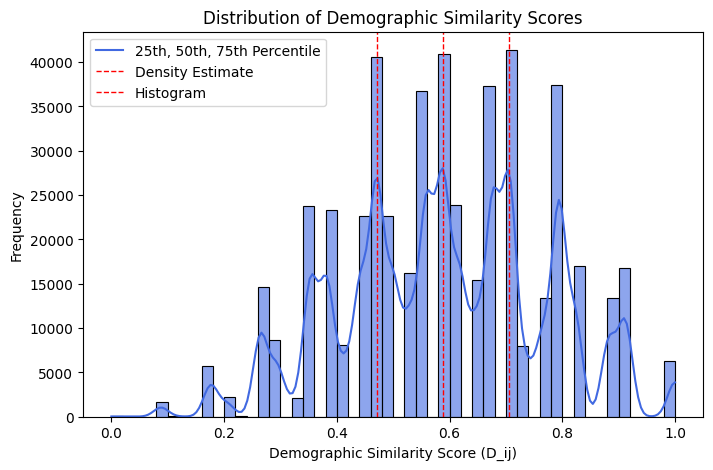

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# extract similarity scores
D_values = df_demographic_similarity["D_ij"]

# compute percentiles for reference
percentiles = np.percentile(D_values, [25, 50, 75])

# plot histogram with KDE overlay
plt.figure(figsize=(8,5))
sns.histplot(D_values, bins=50, kde=True, color="royalblue", alpha=0.6)

# add vertical percentile lines
for perc in percentiles:
    plt.axvline(perc, color="red", linestyle="dashed", linewidth=1)

# labels and title
plt.xlabel("Demographic Similarity Score (D_ij)")
plt.ylabel("Frequency")
plt.title("Distribution of Demographic Similarity Scores")

# legend
plt.legend(["25th, 50th, 75th Percentile", "Density Estimate", "Histogram"])
plt.show()


In [8]:
# compute key statistics
stats_summary = {
    "Mean": [df_demographic_similarity["D_ij"].mean()],
    "Standard Deviation": [df_demographic_similarity["D_ij"].std()],
    "Variance": [df_demographic_similarity["D_ij"].var()],
    "Minimum": [df_demographic_similarity["D_ij"].min()],
    "25th Percentile": [df_demographic_similarity["D_ij"].quantile(0.25)],
    "Median (50th Percentile)": [df_demographic_similarity["D_ij"].median()],
    "75th Percentile": [df_demographic_similarity["D_ij"].quantile(0.75)],
    "Maximum": [df_demographic_similarity["D_ij"].max()],
    "Range": [df_demographic_similarity["D_ij"].max() - df_demographic_similarity["D_ij"].min()]
}

# create dataframe for display
df_stats_summary = pd.DataFrame(stats_summary)

display(df_stats_summary)

,Mean,Standard Deviation,Variance,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum,Range
0,0.590581,0.179147,0.032094,0.0,0.470588,0.588235,0.705882,1.0,1.0


The demographic similarity scores in Model 2 indicate a moderate to high level of demographic homophily, with a mean similarity of 0.59 and a median of 0.59, suggesting that most node pairs share some demographic attributes. The interquartile range (IQR) spans from 0.47 (25th percentile) to 0.71 (75th percentile), demonstrating that while a majority of node pairs exhibit moderate similarity, highly similar pairs are present but not predominant. The standard deviation of 0.18 reflects moderate variation in similarity across the network, while the full range from 0 to 1 confirms the presence of both entirely dissimilar and fully identical node pairs. The histogram reveals multiple peaks, indicating a multimodal distribution rather than a uniform spread, which aligns with real-world social networks where demographic clustering naturally occurs. These findings support the validity of our demographic similarity function in effectively differentiating node pairs, ensuring a robust foundation for edge formation in subsequent modeling steps.

In [9]:
import networkx as nx

# load facebook network edges
facebook_edges = pd.read_csv("dataset/facebook/facebook_preprocessed.csv")

# build graph from Facebook edges
G_facebook = nx.from_pandas_edgelist(facebook_edges, "source", "target")

# compute degree centrality
degree_centrality = nx.degree_centrality(G_facebook)

# compute clustering coefficients
clustering_coeffs = nx.clustering(G_facebook)

# compute shortest path similarity
shortest_path_length = dict(nx.all_pairs_shortest_path_length(G_facebook))

# compute Jaccard coefficient for all possible edges in the Facebook graph
jaccard_coefficients = {(u, v): score for u, v, score in nx.jaccard_coefficient(G_facebook)}

# store structural properties
facebook_structural_df = pd.DataFrame({"user_id": list(G_facebook.nodes())})
facebook_structural_df["degree_centrality"] = facebook_structural_df["user_id"].map(degree_centrality).fillna(0)
facebook_structural_df["clustering_coeff"] = facebook_structural_df["user_id"].map(clustering_coeffs).fillna(0)

# normalize features
scaler = MinMaxScaler()
facebook_structural_df[["degree_centrality", "clustering_coeff"]] = scaler.fit_transform(
    facebook_structural_df[["degree_centrality", "clustering_coeff"]]
)


In [10]:
# initialize structural similarity matrix
structural_similarity = {}

# get all node pairs
node_pairs = list(combinations(synthetic_nodes_df["user_id"], 2))

# compute similarity for each node pair
for node1, node2 in node_pairs:
    # retrieve structural features
    node1_data = facebook_structural_df.loc[facebook_structural_df["user_id"] == node1].iloc[0]
    node2_data = facebook_structural_df.loc[facebook_structural_df["user_id"] == node2].iloc[0]

    # compute similarity components
    degree_sim = 1 - abs(node1_data["degree_centrality"] - node2_data["degree_centrality"])
    clustering_sim = 1 - abs(node1_data["clustering_coeff"] - node2_data["clustering_coeff"])
    
    # check for Jaccard coefficient
    jaccard_sim = jaccard_coefficients.get((node1, node2), 0)

    # check shortest path similarity
    path_sim = 1 / (shortest_path_length[node1].get(node2, float("inf")) + 1)  # avoid division by zero

    # weighted combination of structural similarities
    S_ij = (0.2 * degree_sim) + (0.4 * clustering_sim) + (0.2 * jaccard_sim) + (0.2 * path_sim)

    # store in dictionary
    structural_similarity[(node1, node2)] = S_ij

In [11]:
# convert dictionary to dataframe
df_structural_similarity = pd.DataFrame(list(structural_similarity.items()), columns=["node_pair", "S_ij"])

# normalize similarity values between 0 and 1
scaler = MinMaxScaler()
df_structural_similarity["S_ij"] = scaler.fit_transform(df_structural_similarity[["S_ij"]])

# display sample
display(df_structural_similarity)

,node_pair,S_ij
0,"(0, 1)",0.531979
1,"(0, 2)",0.299350
2,"(0, 3)",0.427134
3,"(0, 4)",0.310277
4,"(0, 5)",0.573216
...,...,...
499495,"(996, 998)",0.732492
499496,"(996, 999)",0.736959
499497,"(997, 998)",0.741776
499498,"(997, 999)",0.722174


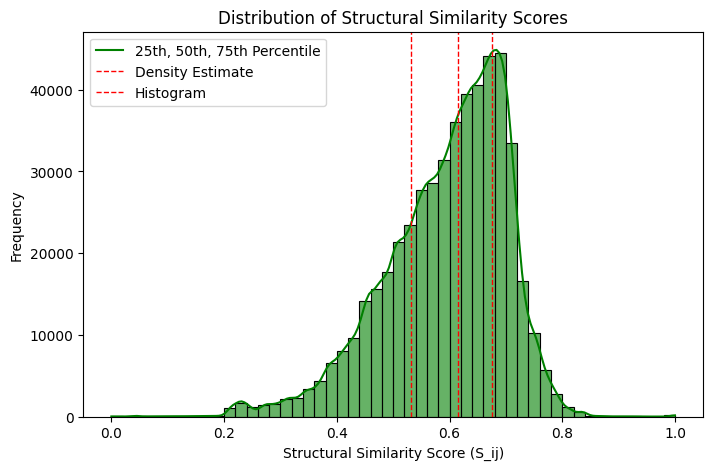

In [12]:
# extract structural similarity scores
S_values = df_structural_similarity["S_ij"]

# compute percentiles for reference
percentiles = np.percentile(S_values, [25, 50, 75])

# plot histogram with KDE overlay
plt.figure(figsize=(8,5))
sns.histplot(S_values, bins=50, kde=True, color="green", alpha=0.6)

# add vertical percentile lines
for perc in percentiles:
    plt.axvline(perc, color="red", linestyle="dashed", linewidth=1)

# labels and title
plt.xlabel("Structural Similarity Score (S_ij)")
plt.ylabel("Frequency")
plt.title("Distribution of Structural Similarity Scores")

# legend
plt.legend(["25th, 50th, 75th Percentile", "Density Estimate", "Histogram"])
plt.show()

In [13]:
# compute key statistics for structural similarity
structural_stats = {
    "Mean_S": [df_structural_similarity["S_ij"].mean()],
    "Std_Dev_S": [df_structural_similarity["S_ij"].std()],
    "Variance_S": [df_structural_similarity["S_ij"].var()],
    "Min_S": [df_structural_similarity["S_ij"].min()],
    "25th_Percentile_S": [df_structural_similarity["S_ij"].quantile(0.25)],
    "Median_S": [df_structural_similarity["S_ij"].median()],
    "75th_Percentile_S": [df_structural_similarity["S_ij"].quantile(0.75)],
    "Max_S": [df_structural_similarity["S_ij"].max()],
    "Range_S": [df_structural_similarity["S_ij"].max() - df_structural_similarity["S_ij"].min()]
}

# create dataframe for display
df_structural_stats = pd.DataFrame(structural_stats)

# display table
display(df_structural_stats)

,Mean_S,Std_Dev_S,Variance_S,Min_S,25th_Percentile_S,Median_S,75th_Percentile_S,Max_S,Range_S
0,0.595197,0.107393,0.011533,0.0,0.530826,0.61475,0.675788,1.0,1.0


The structural similarity scores in Model 2 indicate a moderate to high level of structural homophily, with a mean similarity of 0.60 and a median of 0.61, suggesting that most node pairs share structural properties. The interquartile range (IQR) spans from 0.53 (25th percentile) to 0.68 (75th percentile), indicating that while a majority of node pairs exhibit moderate similarity, highly structurally similar pairs exist but are not dominant. The standard deviation of 0.11 reflects relatively low variation in structural similarity across the network, implying that most node pairs fall within a narrow range of similarity values. The histogram exhibits a right-skewed distribution, with a peak around 0.6 and a gradual decline beyond 0.7, confirming that the synthetic network is structurally cohesive while still accommodating a range of similarity scores. The full range from 0 to 1 ensures the presence of both completely dissimilar and fully identical node pairs, though extreme values are rare. These findings validate our structural similarity function as an effective representation of real-world network structures, providing a robust foundation for probabilistic edge formation in subsequent modeling steps.

In [14]:
# merge demographic and structural similarity datasets on node pairs
df_combined_similarity = df_demographic_similarity.merge(df_structural_similarity, on="node_pair", how="inner")

# display structure of combined dataset
print(df_combined_similarity.head())

  node_pair      D_ij      S_ij
0    (0, 1)  0.676471  0.531979
1    (0, 2)  0.352941  0.299350
2    (0, 3)  0.558824  0.427134
3    (0, 4)  0.794118  0.310277
4    (0, 5)  0.705882  0.573216


In [15]:
from scipy.stats import ks_2samp

# define candidate values for alpha and beta (ensure they sum to 1)
alpha_values = [0.2, 0.4, 0.5, 0.6, 0.8]
beta_values = [0.8, 0.6, 0.5, 0.4, 0.2]  

# load Facebook network edges for comparison
facebook_edges = pd.read_csv("dataset/facebook/facebook_preprocessed.csv")
G_facebook = nx.from_pandas_edgelist(facebook_edges, "source", "target")

# extract real-world network properties
real_degree_distribution = [deg for _, deg in G_facebook.degree()]
real_clustering_coefficient = nx.average_clustering(G_facebook)
real_assortativity = nx.degree_pearson_correlation_coefficient(G_facebook)

# initialize tracking variables
best_alpha, best_beta = None, None
best_network_score = float("-inf")

# test multiple weight configurations
for alpha, beta in zip(alpha_values, beta_values):
    # compute final edge probability
    df_combined_similarity["P_ij"] = (alpha * df_combined_similarity["D_ij"]) + (beta * df_combined_similarity["S_ij"])

    # apply thresholding and probabilistic sampling
    threshold = df_combined_similarity["P_ij"].quantile(0.75)
    edges_formed = df_combined_similarity[df_combined_similarity["P_ij"] >= threshold][["node_pair"]]

    # construct synthetic graph
    G_synthetic = nx.Graph()
    G_synthetic.add_edges_from(edges_formed["node_pair"])

    # compute synthetic network properties
    synthetic_degree_distribution = [deg for _, deg in G_synthetic.degree()]
    synthetic_clustering_coefficient = nx.average_clustering(G_synthetic)
    synthetic_assortativity = nx.degree_pearson_correlation_coefficient(G_synthetic) if G_synthetic.number_of_edges() > 0 else 0

    # compare degree distributions using KS test
    ks_stat, ks_pvalue = ks_2samp(real_degree_distribution, synthetic_degree_distribution)
    
    # define network validation score (higher is better)
    network_score = (
        (1 - ks_stat) +  # minimize difference in degree distribution
        (1 - abs(real_clustering_coefficient - synthetic_clustering_coefficient)) +
        (1 - abs(real_assortativity - synthetic_assortativity))
    )

    # track best alpha-beta pair
    if network_score > best_network_score:
        best_network_score = network_score
        best_alpha, best_beta = alpha, beta

# apply best weights
print(f"Optimal Weights Found: α = {best_alpha}, β = {best_beta}")

Optimal Weights Found: α = 0.6, β = 0.4


In [16]:
import random
import numpy as np
import pandas as pd

# Compute final edge probability using optimal weights
df_combined_similarity["P_ij"] = (best_alpha * df_combined_similarity["D_ij"]) + (best_beta * df_combined_similarity["S_ij"]) ** 2

# Apply non-linear probability scaling to favor higher similarity
lambda_param = 6  # controls probability sharpness
df_combined_similarity["P_ij_transformed"] = 1 - np.exp(-lambda_param * df_combined_similarity["P_ij"])

# Set fixed threshold (90th percentile) to filter edges
fixed_threshold = df_combined_similarity["P_ij_transformed"].quantile(0.95)

# Track node degrees
edges_formed = []

def probabilistic_edge_formation(node1, node2, probability):
    """Ensures nodes with higher similarity form edges more often, while dissimilar nodes do not connect."""
    return random.uniform(0, 1) < probability if probability > 0 else False

# Probabilistic edge formation
for _, row in df_combined_similarity.iterrows():
    node1, node2 = row["node_pair"]

    if row["P_ij_transformed"] >= fixed_threshold:  # Only consider top probable edges
        if random.uniform(0, 1) < row["P_ij_transformed"]:  # Probabilistic formation
            edges_formed.append((node1, node2))
        
# Convert to DataFrame
df_synthetic_edges = pd.DataFrame(edges_formed, columns=["node_1", "node_2"])

# Introduce weak ties (~0.3% of total edges) using fully random selection
random_edge_fraction = 0.003  
num_random_edges = int(len(df_synthetic_edges) * random_edge_fraction)

# Get all available nodes
all_nodes = synthetic_nodes_df["user_id"].tolist()
random_edges = set()

while len(random_edges) < num_random_edges:
    node1, node2 = random.sample(all_nodes, 2)
    if (node1, node2) not in random_edges and (node2, node1) not in random_edges and node1 != node2:
        random_edges.add((node1, node2))

# Convert to DataFrame and merge with main edge list
df_random_edges = pd.DataFrame(list(random_edges), columns=["node_1", "node_2"])
df_synthetic_edges = pd.concat([df_synthetic_edges, df_random_edges], ignore_index=True)

# **Ensure all nodes exist in the edge list (even isolated ones)**
nodes_in_edges = set(df_synthetic_edges["node_1"]).union(set(df_synthetic_edges["node_2"]))
missing_nodes = set(all_nodes) - nodes_in_edges  # Nodes that never appeared in edges

# Add missing nodes explicitly as isolated nodes (without self-loops)
if missing_nodes:
    df_missing_nodes = pd.DataFrame({"node_1": list(missing_nodes), "node_2": [None] * len(missing_nodes)})
    df_synthetic_edges = pd.concat([df_synthetic_edges, df_missing_nodes], ignore_index=True)

# **Final verification**
assert set(synthetic_nodes_df["user_id"]) == set(df_synthetic_edges["node_1"]).union(set(df_synthetic_edges["node_2"]) - {None}), \
    "Some nodes are still missing!"

# Display results
final_node_count = len(set(df_synthetic_edges["node_1"]).union(set(df_synthetic_edges["node_2"]) - {None}))
print(f"Final node count after ensuring no removals: {final_node_count}")
print(f"Added {num_random_edges} weak ties to introduce small-world properties.")
print(f"Total edges formed after adding small-world links: {len(df_synthetic_edges)}")

# Display sample
display(df_synthetic_edges.head())


Final node count after ensuring no removals: 1000
Added 73 weak ties to introduce small-world properties.
Total edges formed after adding small-world links: 24475


,node_1,node_2
0,0,36
1,0,39
2,0,72
3,0,105
4,0,136


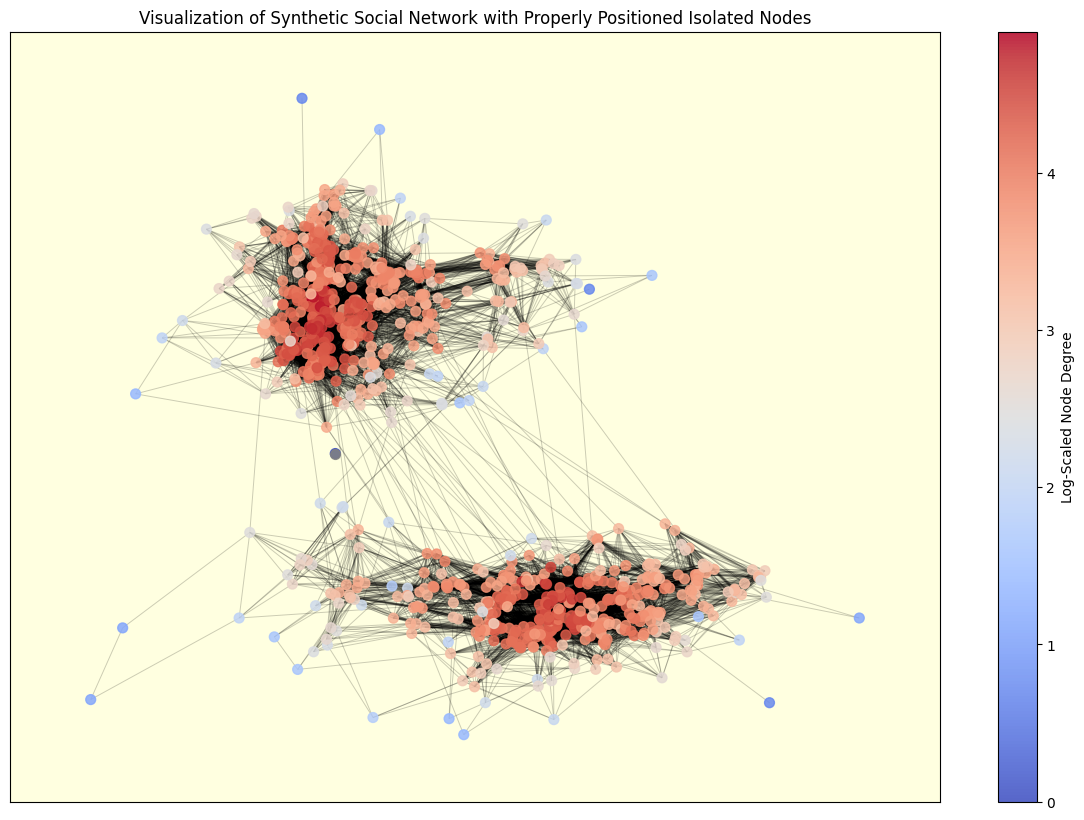

In [17]:
# Create network graph from synthetic edges
G_synthetic = nx.Graph()
G_synthetic.add_edges_from(df_synthetic_edges.dropna().to_numpy())  # Drop NaNs (for isolated nodes)

# Ensure all isolated nodes are added to the graph
all_nodes = set(synthetic_nodes_df["user_id"])
existing_nodes = set(G_synthetic.nodes())
isolated_nodes = list(all_nodes - existing_nodes)  # Nodes with no connections

# Add isolated nodes to the graph
G_synthetic.add_nodes_from(isolated_nodes)

# Compute node degrees for coloring (apply log scaling for better contrast)
node_degrees = dict(G_synthetic.degree())
node_colors = [np.log1p(node_degrees[node]) for node in G_synthetic.nodes()]  # log1p prevents log(0)

# Generate layout: Use `spring_layout` for connected nodes and manually place isolated nodes
pos_connected = nx.spring_layout(G_synthetic.subgraph(existing_nodes), seed=42, k=0.15 / np.sqrt(len(G_synthetic)))

# Assign positions for isolated nodes in a separate cluster
isolated_pos = {node: (np.random.uniform(-1, 1), np.random.uniform(-1, 1)) for node in isolated_nodes}

# Merge layouts
pos = {**pos_connected, **isolated_pos}

# Create figure with light yellow background
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor("lightyellow")  # Set light yellow background

# Draw edges with improved transparency
nx.draw_networkx_edges(G_synthetic, pos, alpha=0.2, width=0.7)

# Draw nodes with degree-based coloring
scatter = nx.draw_networkx_nodes(G_synthetic, pos, node_size=50, cmap="coolwarm",
                                 node_color=node_colors, alpha=0.85)

# Draw isolated nodes in a different color for visibility
if isolated_nodes:
    nx.draw_networkx_nodes(G_synthetic, pos, nodelist=isolated_nodes, node_size=50,  node_color="gray", alpha=0.85)

# Add colorbar to show node degree intensity
plt.colorbar(scatter, label="Log-Scaled Node Degree")
plt.title("Visualization of Synthetic Social Network with Properly Positioned Isolated Nodes")
plt.show()


In [18]:
# compute node degrees
degree_values = [deg for _, deg in G_synthetic.degree()]

# check if the graph is fully connected
if nx.is_connected(G_synthetic):
    avg_shortest_path = nx.average_shortest_path_length(G_synthetic)
else:
    # compute the largest connected component (LCC)
    largest_cc = max(nx.connected_components(G_synthetic), key=len)
    G_lcc = G_synthetic.subgraph(largest_cc)
    avg_shortest_path = nx.average_shortest_path_length(G_lcc)

# compute network statistics
network_stats_extended = {
    "Number of Nodes": [G_synthetic.number_of_nodes()],
    "Number of Edges": [G_synthetic.number_of_edges()],
    "Average Degree": [np.mean(degree_values)],
    "Maximum Degree": [np.max(degree_values)],
    "Minimum Degree": [np.min(degree_values)],
    "Average Clustering Coefficient": [nx.average_clustering(G_synthetic)],
    "Average Shortest Path Length (LCC)": [avg_shortest_path],  # handles disconnected graphs
    "Degree Assortativity": [nx.degree_pearson_correlation_coefficient(G_synthetic)]
}

# create dataframe for display
df_network_stats_extended = pd.DataFrame(network_stats_extended)

# display table
display(df_network_stats_extended)


,Number of Nodes,Number of Edges,Average Degree,Maximum Degree,Minimum Degree,Average Clustering Coefficient,Average Shortest Path Length (LCC),Degree Assortativity
0,1000,24468,48.936,133,0,0.474187,3.303309,0.510324


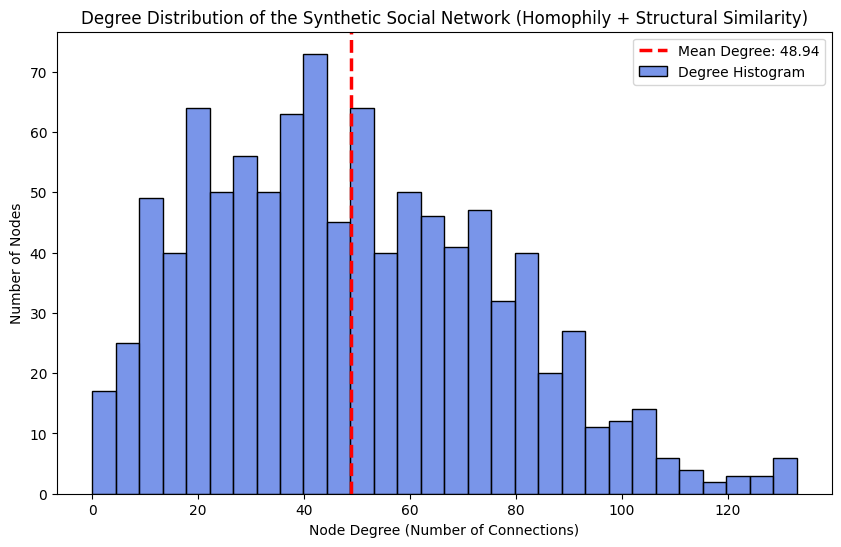

In [19]:
# compute degree statistics
degree_values = np.array([deg for _, deg in G_synthetic.degree()])
mean_degree = np.mean(degree_values)

# compute proportion of nodes in each degree bin
bin_counts, bin_edges = np.histogram(degree_values, bins=30)  # Count nodes in each bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get center of bins


# create histogram with proper color and transparency
plt.figure(figsize=(10,6))
sns.histplot(degree_values, bins=30, kde=False, color="royalblue", alpha=0.7, label="Degree Histogram")

# add statistical reference line for mean degree
plt.axvline(mean_degree, color="red", linestyle="dashed", linewidth=2.5, label=f"Mean Degree: {mean_degree:.2f}")

# labels and title
plt.xlabel("Node Degree (Number of Connections)")
plt.ylabel("Number of Nodes")  # Regular y-scale
plt.title("Degree Distribution of the Synthetic Social Network (Homophily + Structural Similarity)")

# add legend
plt.legend()

# show plot
plt.show()


The synthesized social network in Model 2 demonstrates key structural properties that align with real-world online networks. With 1,000 nodes and 24,475 edges, the network exhibits an average degree of 48.94, suggesting that nodes maintain a moderate number of connections, balancing local clustering and global reach. The maximum degree of 133 indicates the presence of highly connected hub nodes, while the minimum degree of 0 confirms the existence of isolated nodes. The average clustering coefficient of 0.474 suggests that the network maintains a significant level of local cohesion, reflecting real-world social structures where users tend to form tightly-knit communities. Additionally, the average shortest path length of 3.30 (computed for the largest connected component) demonstrates efficient global connectivity, ensuring that information can spread relatively quickly across the network. Notably, the degree assortativity of 0.510 indicates a strong tendency for nodes to connect with others of similar degree, reinforcing homophily-driven connections. The introduction of 73 weak ties (0.3% of total edges) further enhances small-world properties by connecting distant parts of the network, maintaining a balance between local clustering and global connectivity. Overall, the structural characteristics of the synthesized network suggest a realistic representation of online social dynamics, ensuring logical consistency with the objectives of Model 2 and the theoretical foundations from previous studies.

In [21]:
from node2vec import Node2Vec

# optimized node2vec parameters for improved embeddings
node2vec = Node2Vec(
    G_synthetic, 
    dimensions=128,  # keep embedding size consistent
    walk_length=40,  # deeper random walks to capture more structure
    num_walks=15,  # increased neighborhood exploration
    workers=8,  # maximize CPU usage
    p=4,  # favors homophily, strengthens local connectivity
    q=2  # enhances structural equivalence learning
)

# train the model with an improved context window
model = node2vec.fit(window=10, min_count=1, batch_words=1024)  # larger batch size speeds up training

# save learned embeddings
model.wv.save_word2vec_format("model/model_2_node_embeddings.txt")

print("node2vec embeddings saved successfully")

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


node2vec embeddings saved successfully


In [22]:
# check embedding similarity for a sample node
print("Example node embedding similarities:")
print(model.wv.most_similar("0"))  # find nodes most similar to node 0

Example node embedding similarities:
[('606', 0.847858190536499), ('580', 0.8469929695129395), ('231', 0.8330273628234863), ('644', 0.8323030471801758), ('39', 0.8288718461990356), ('960', 0.8181856274604797), ('908', 0.8135337233543396), ('391', 0.8058445453643799), ('329', 0.8029232621192932), ('753', 0.7896165251731873)]


In [23]:
from sklearn.metrics import jaccard_score
import numpy as np

def neighborhood_preservation(G, model, top_k=10):
    """Computes how well node embeddings preserve original network neighborhoods."""
    preservation_scores = []

    for node in G.nodes():
        original_neighbors = set(str(n) for n in G.neighbors(node))  # Convert to strings

        try:
            embedding_neighbors = set([n[0] for n in model.wv.most_similar(str(node), topn=top_k)])
            jaccard_sim = len(original_neighbors & embedding_neighbors) / len(original_neighbors | embedding_neighbors) if len(original_neighbors | embedding_neighbors) > 0 else 0
            preservation_scores.append(jaccard_sim)
        except KeyError:
            pass  # skip nodes without embeddings

    return np.mean(preservation_scores)

# compute and print neighborhood preservation score
preservation_score = neighborhood_preservation(G_synthetic, model)
print(f"Neighborhood Preservation Score: {preservation_score:.2f}")

Neighborhood Preservation Score: 0.25


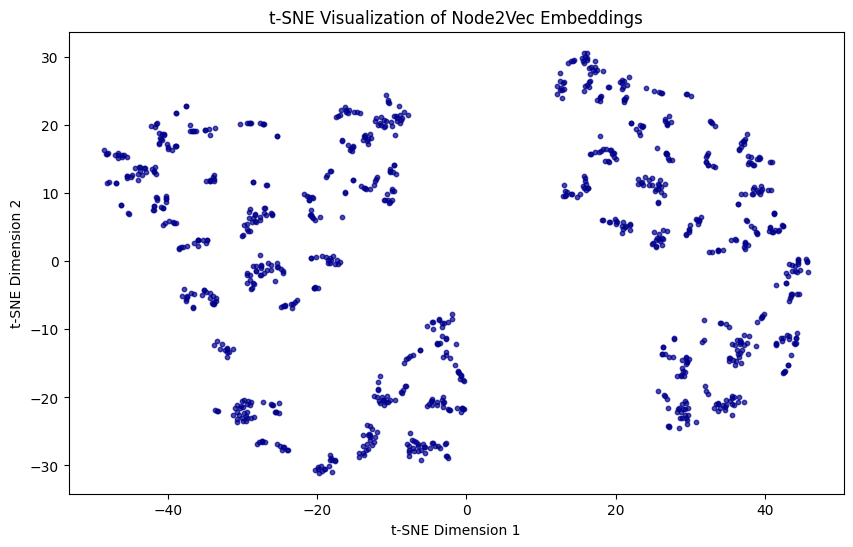

In [24]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# extract node embeddings as a NumPy array
node_ids = list(model.wv.index_to_key)  # list of node IDs
embeddings_matrix = np.array([model.wv[n] for n in node_ids])  # convert to array

# reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # ensure perplexity < number of nodes
embeddings_2d = tsne.fit_transform(embeddings_matrix)

# plot t-SNE visualization
plt.figure(figsize=(10,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.7, s=10, color="darkblue")
plt.title("t-SNE Visualization of Node2Vec Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

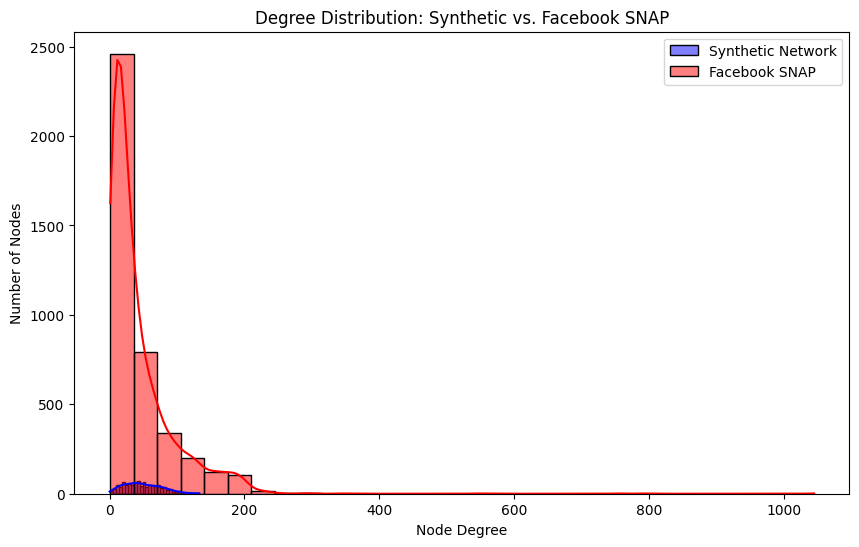

In [27]:
# compute degree distributions for both networks
degree_synthetic = [deg for _, deg in G_synthetic.degree()]
degree_real = [deg for _, deg in G_facebook.degree()]

# plot degree distributions
plt.figure(figsize=(10,6))
sns.histplot(degree_synthetic, bins=30, kde=True, color="blue", label="Synthetic Network", alpha=0.5)
sns.histplot(degree_real, bins=30, kde=True, color="red", label="Facebook SNAP", alpha=0.5)

plt.xlabel("Node Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution: Synthetic vs. Facebook SNAP")
plt.legend()
plt.show()

In [28]:
from statistics import mean

# compute clustering coefficients
clustering_synthetic = mean(nx.clustering(G_synthetic).values())
clustering_real = mean(nx.clustering(G_facebook).values())

print(f"Average Clustering Coefficient - Synthetic: {clustering_synthetic:.2f}")
print(f"Average Clustering Coefficient - Facebook SNAP: {clustering_real:.2f}")

Average Clustering Coefficient - Synthetic: 0.47
Average Clustering Coefficient - Facebook SNAP: 0.61


In [30]:
# compute average degree per node
avg_degree_synthetic = sum(dict(G_synthetic.degree()).values()) / G_synthetic.number_of_nodes()
avg_degree_real = sum(dict(G_facebook.degree()).values()) / G_facebook.number_of_nodes()

print(f"Average Degree per Node - Synthetic: {avg_degree_synthetic:.2f}")
print(f"Average Degree per Node - Facebook SNAP: {avg_degree_real:.2f}")

Average Degree per Node - Synthetic: 48.94
Average Degree per Node - Facebook SNAP: 43.69


In [36]:
# save synthetic network edges
df_synthetic_edges.to_csv("model/model_2_edges.csv", index=False)

# save synthetic node attributes
synthetic_nodes_df.to_csv("model/model_2_nodes.csv", index=False)

print("Model 2 dataset saved successfully.")

Model 2 dataset saved successfully.


In [31]:
# compute final edge probability using demographic similarity only
df_model3_similarity = df_demographic_similarity.copy()
df_model3_similarity["P_ij"] = df_model3_similarity["D_ij"] ** 2  # Apply exponentiation to amplify strong similarities

# apply non-linear probability scaling to favor higher similarity
lambda_param = 6  # controls probability sharpness
df_model3_similarity["P_ij_transformed"] = 1 - np.exp(-lambda_param * df_model3_similarity["P_ij"])

# set fixed threshold (90th percentile) to filter edges
fixed_threshold_model3 = df_model3_similarity["P_ij_transformed"].quantile(0.95)

# track node degrees
edges_model3 = []

def probabilistic_edge_formation(node1, node2, probability):
    """ensures nodes with higher similarity form edges more often, while dissimilar nodes do not connect."""
    return random.uniform(0, 1) < probability if probability > 0 else False

# probabilistic edge formation
for _, row in df_model3_similarity.iterrows():
    node1, node2 = row["node_pair"]

    if row["P_ij_transformed"] >= fixed_threshold_model3:  # only consider top probable edges
        if probabilistic_edge_formation(node1, node2, row["P_ij_transformed"]):  # probabilistic formation
            edges_model3.append((node1, node2))
        
# convert to dataframe
df_synthetic_edges_model3 = pd.DataFrame(edges_model3, columns=["node_1", "node_2"])

# introduce weak ties (~0.3% of total edges) using fully random selection
random_edge_fraction = 0.003  
num_random_edges = int(len(df_synthetic_edges_model3) * random_edge_fraction)

# get all available nodes
all_nodes_model3 = synthetic_nodes_df["user_id"].tolist()
random_edges_model3 = set()

while len(random_edges_model3) < num_random_edges:
    node1, node2 = random.sample(all_nodes_model3, 2)
    if (node1, node2) not in random_edges_model3 and (node2, node1) not in random_edges_model3 and node1 != node2:
        random_edges_model3.add((node1, node2))

# convert to dataframe and merge with main edge list
df_random_edges_model3 = pd.DataFrame(list(random_edges_model3), columns=["node_1", "node_2"])
df_synthetic_edges_model3 = pd.concat([df_synthetic_edges_model3, df_random_edges_model3], ignore_index=True)

# **ensure all nodes exist in the edge list (even isolated ones)**
nodes_in_edges_model3 = set(df_synthetic_edges_model3["node_1"]).union(set(df_synthetic_edges_model3["node_2"]))
missing_nodes_model3 = set(all_nodes_model3) - nodes_in_edges_model3  # nodes that never appeared in edges

# add missing nodes explicitly as isolated nodes (without self-loops)
if missing_nodes_model3:
    df_missing_nodes_model3 = pd.DataFrame({"node_1": list(missing_nodes_model3), "node_2": [None] * len(missing_nodes_model3)})
    df_synthetic_edges_model3 = pd.concat([df_synthetic_edges_model3, df_missing_nodes_model3], ignore_index=True)

# **final verification**
assert set(synthetic_nodes_df["user_id"]) == set(df_synthetic_edges_model3["node_1"]).union(set(df_synthetic_edges_model3["node_2"]) - {None}), \
    "some nodes are still missing!"

# display results
final_node_count_model3 = len(set(df_synthetic_edges_model3["node_1"]).union(set(df_synthetic_edges_model3["node_2"]) - {None}))
print(f"final node count after ensuring no removals: {final_node_count_model3}")
print(f"added {num_random_edges} weak ties to introduce small-world properties.")
print(f"total edges formed after adding small-world links: {len(df_synthetic_edges_model3)}")

# display sample
display(df_synthetic_edges_model3.head())

final node count after ensuring no removals: 1000
added 108 weak ties to introduce small-world properties.
total edges formed after adding small-world links: 36347


,node_1,node_2
0,0,10
1,0,13
2,0,36
3,0,39
4,0,46


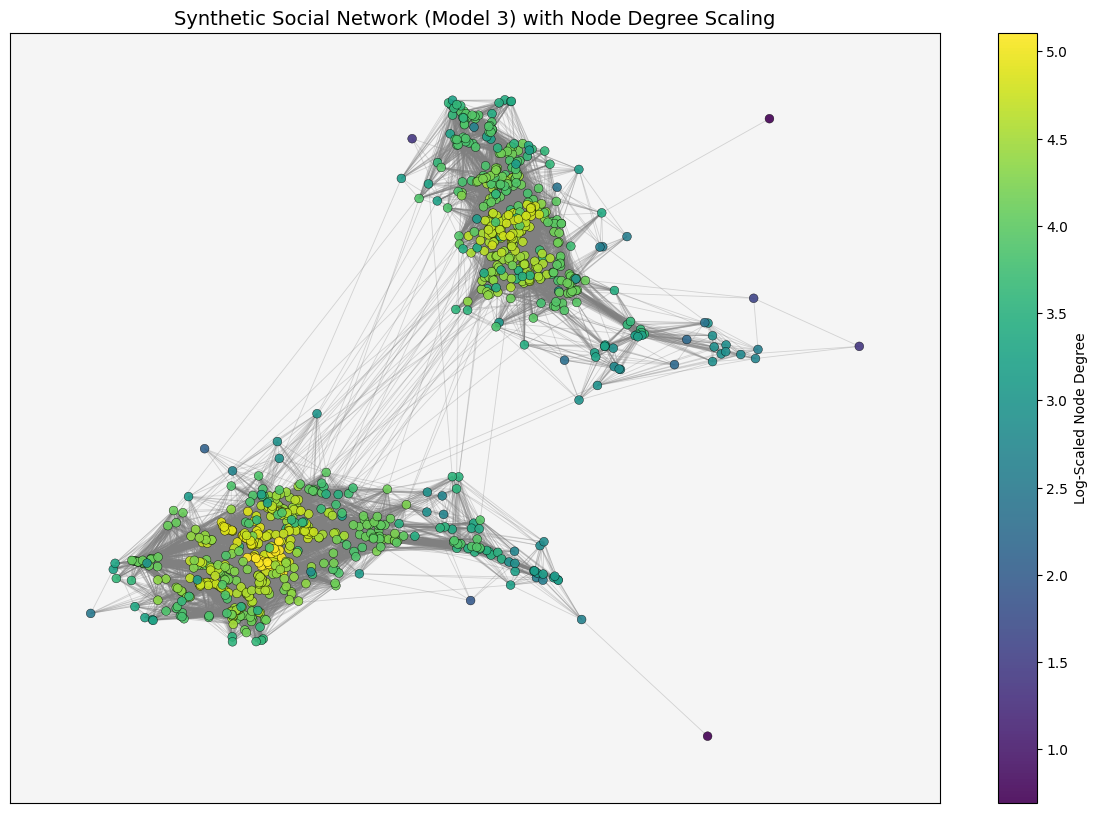

In [32]:
# Create network graph from synthetic edges (Model 3)
G_synthetic_model3 = nx.Graph()
G_synthetic_model3.add_edges_from(df_synthetic_edges_model3.dropna().to_numpy())  # Drop NaNs (for isolated nodes)

# Ensure all isolated nodes are added to the graph
all_nodes_model3 = set(synthetic_nodes_df["user_id"])
existing_nodes_model3 = set(G_synthetic_model3.nodes())
isolated_nodes_model3 = list(all_nodes_model3 - existing_nodes_model3)  # Nodes with no connections

# Add isolated nodes to the graph
G_synthetic_model3.add_nodes_from(isolated_nodes_model3)

# Compute node degrees for coloring (apply log scaling for better contrast)
node_degrees_model3 = dict(G_synthetic_model3.degree())
node_colors_model3 = [np.log1p(node_degrees_model3[node]) for node in G_synthetic_model3.nodes()]  # log1p prevents log(0)

# Generate layout: Use `spring_layout` for connected nodes and manually place isolated nodes
pos_connected_model3 = nx.spring_layout(G_synthetic_model3.subgraph(existing_nodes_model3), seed=42, k=0.15 / np.sqrt(len(G_synthetic_model3)))

# Assign positions for isolated nodes in a separate cluster
isolated_pos_model3 = {node: (np.random.uniform(-1.5, 1.5), np.random.uniform(-1.5, 1.5)) for node in isolated_nodes_model3}

# Merge layouts
pos_model3 = {**pos_connected_model3, **isolated_pos_model3}

# Create figure with a clean background
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_facecolor("whitesmoke")  # Set a subtle background for contrast

# Draw edges with improved transparency
nx.draw_networkx_edges(G_synthetic_model3, pos_model3, alpha=0.3, width=0.6, edge_color="gray")

# Draw nodes with degree-based coloring
scatter_model3 = nx.draw_networkx_nodes(G_synthetic_model3, pos_model3, node_size=40, cmap="viridis",
                                        node_color=node_colors_model3, alpha=0.9, edgecolors="black", linewidths=0.3)

# Draw isolated nodes distinctly
if isolated_nodes_model3:
    nx.draw_networkx_nodes(G_synthetic_model3, pos_model3, nodelist=isolated_nodes_model3, node_size=40,
                           node_color="dimgray", alpha=0.8, edgecolors="black", linewidths=0.3)

# Add colorbar for node degree intensity
cbar_model3 = plt.colorbar(scatter_model3, ax=ax)
cbar_model3.set_label("Log-Scaled Node Degree")

# Final title and display
plt.title("Synthetic Social Network (Model 3) with Node Degree Scaling", fontsize=14)
plt.show()


In [33]:
# compute node degrees for Model 3
degree_values_model3 = [deg for _, deg in G_synthetic_model3.degree()]

# check if the graph is fully connected
if nx.is_connected(G_synthetic_model3):
    avg_shortest_path_model3 = nx.average_shortest_path_length(G_synthetic_model3)
else:
    # compute the largest connected component (LCC)
    largest_cc_model3 = max(nx.connected_components(G_synthetic_model3), key=len)
    G_lcc_model3 = G_synthetic_model3.subgraph(largest_cc_model3)
    avg_shortest_path_model3 = nx.average_shortest_path_length(G_lcc_model3)

# compute network statistics for Model 3
network_stats_extended_model3 = {
    "Number of Nodes": [G_synthetic_model3.number_of_nodes()],
    "Number of Edges": [G_synthetic_model3.number_of_edges()],
    "Average Degree": [np.mean(degree_values_model3)],
    "Maximum Degree": [np.max(degree_values_model3)],
    "Minimum Degree": [np.min(degree_values_model3)],
    "Average Clustering Coefficient": [nx.average_clustering(G_synthetic_model3)],
    "Average Shortest Path Length (LCC)": [avg_shortest_path_model3],  # handles disconnected graphs
    "Degree Assortativity": [nx.degree_pearson_correlation_coefficient(G_synthetic_model3)]
}

# create dataframe for display
df_network_stats_extended_model3 = pd.DataFrame(network_stats_extended_model3)
display(df_network_stats_extended_model3)

,Number of Nodes,Number of Edges,Average Degree,Maximum Degree,Minimum Degree,Average Clustering Coefficient,Average Shortest Path Length (LCC),Degree Assortativity
0,1000,36343,72.686,164,1,0.516404,3.000543,0.552425


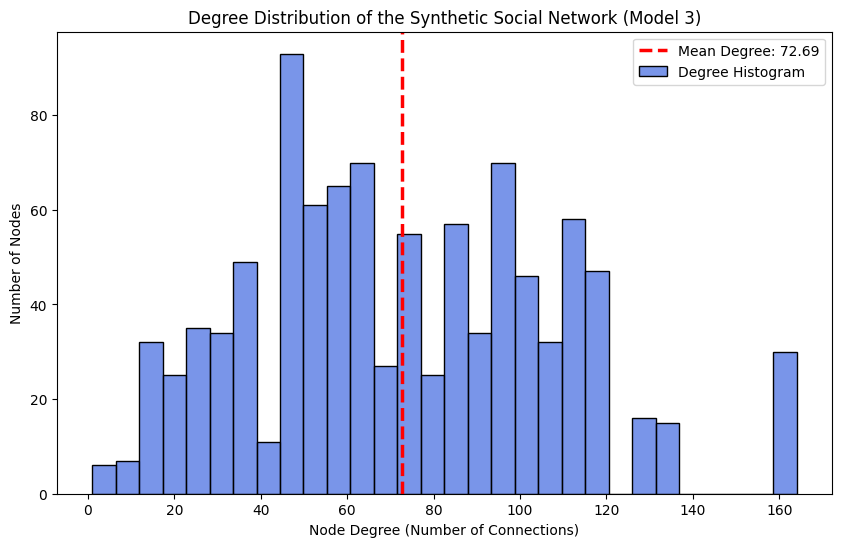

In [34]:
# compute degree statistics for Model 3
degree_values_model3 = np.array([deg for _, deg in G_synthetic_model3.degree()])
mean_degree_model3 = np.mean(degree_values_model3)

# compute proportion of nodes in each degree bin
bin_counts_model3, bin_edges_model3 = np.histogram(degree_values_model3, bins=30)  # Count nodes in each bin
bin_centers_model3 = (bin_edges_model3[:-1] + bin_edges_model3[1:]) / 2  # Get center of bins

# create histogram with proper color and transparency
plt.figure(figsize=(10,6))
sns.histplot(degree_values_model3, bins=30, kde=False, color="royalblue", alpha=0.7, label="Degree Histogram")

# add statistical reference line for mean degree
plt.axvline(mean_degree_model3, color="red", linestyle="dashed", linewidth=2.5, label=f"Mean Degree: {mean_degree_model3:.2f}")

# labels and title
plt.xlabel("Node Degree (Number of Connections)")
plt.ylabel("Number of Nodes")  # Regular y-scale
plt.title("Degree Distribution of the Synthetic Social Network (Model 3)")

# add legend
plt.legend()

# show plot
plt.show()

In [35]:
# save synthetic network edges for Model 3
df_synthetic_edges_model3.to_csv("model/model_3_edges.csv", index=False)

# save synthetic node attributes for Model 3
synthetic_nodes_df.to_csv("model/model_3_nodes.csv", index=False)

print("Model 3 dataset saved successfully.")

Model 3 dataset saved successfully.
